In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.04MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.2MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                                 download=True)

In [7]:
k = len(set(train_dataset.targets.numpy()))
print("num of classes: ",k)

num of classes:  10


In [8]:
class CNN(nn.Module):
    def __init__(self, K, input_shape=(1, 28, 28)):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU()
        )

        # Automatically compute the input size for the dense layers
        conv_output_size = self._get_conv_output_size(input_shape)

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(conv_output_size, 512),  # Use computed size
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )

    def _get_conv_output_size(self, input_shape):
        # Compute the flattened output size after conv layers
        dummy_input = torch.randn(1, *input_shape)  # Batch size = 1
        dummy_output = self.conv_layers(dummy_input)
        return int(torch.prod(torch.tensor(dummy_output.shape[1:])))  # Flattened size

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out


In [9]:
model = CNN(k)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

Using device: cpu


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [13]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for epoch in range(epochs):
    model.train()
    t0=datetime.datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)
      train_loss.append(loss.item())

      loss.backward()
      optimizer.step()

    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss


    print(f'Epoch {epoch+1}/{epochs}.. Training Loss: {train_loss:.3f}.. Test Loss: {test_loss:.3f}.. Time: {datetime.datetime.now()-t0}')

  return train_losses, test_losses

In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15.. Training Loss: 0.645.. Test Loss: 0.478.. Time: 0:00:32.814616
Epoch 2/15.. Training Loss: 0.431.. Test Loss: 0.405.. Time: 0:00:35.015409
Epoch 3/15.. Training Loss: 0.375.. Test Loss: 0.379.. Time: 0:00:35.347604
Epoch 4/15.. Training Loss: 0.339.. Test Loss: 0.349.. Time: 0:00:33.892697
Epoch 5/15.. Training Loss: 0.315.. Test Loss: 0.329.. Time: 0:00:34.801900
Epoch 6/15.. Training Loss: 0.292.. Test Loss: 0.313.. Time: 0:00:35.054038
Epoch 7/15.. Training Loss: 0.274.. Test Loss: 0.305.. Time: 0:00:33.803089
Epoch 8/15.. Training Loss: 0.256.. Test Loss: 0.301.. Time: 0:00:34.231095
Epoch 9/15.. Training Loss: 0.244.. Test Loss: 0.295.. Time: 0:00:33.873509
Epoch 10/15.. Training Loss: 0.227.. Test Loss: 0.291.. Time: 0:00:34.951921
Epoch 11/15.. Training Loss: 0.213.. Test Loss: 0.287.. Time: 0:00:34.220992
Epoch 12/15.. Training Loss: 0.201.. Test Loss: 0.282.. Time: 0:00:33.921714
Epoch 13/15.. Training Loss: 0.191.. Test Loss: 0.283.. Time: 0:00:34.875157
Epoch 14

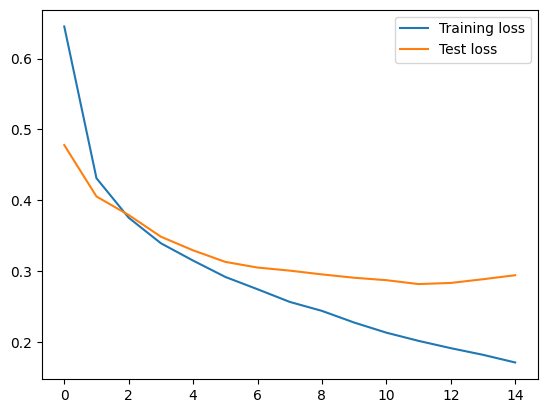

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [18]:
model.eval()
n_correct = 0
n_total = 0
for inputs,targets in train_loader:
  inputs,targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0
n_total = 0
for inputs,targets in test_loader:
  inputs,targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train acc: {train_acc:.3f}, Test acc: {test_acc}')

Train acc: 0.956, Test acc: 0.9043


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  tresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > tresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


Confusion matrix, without normalization
[[849   0  22  14   4   1 106   0   4   0]
 [  1 975   1  16   2   0   3   0   2   0]
 [ 14   0 871  10  43   0  59   0   3   0]
 [  9   5  17 912  26   0  30   0   1   0]
 [  1   1  56  24 811   1 106   0   0   0]
 [  0   0   0   2   0 959   0  28   0  11]
 [ 85   0  58  24  65   0 759   0   9   0]
 [  0   0   0   0   0   6   0 973   0  21]
 [  3   3   5   2   1   1   6   7 972   0]
 [  1   0   0   0   0   3   0  34   0 962]]


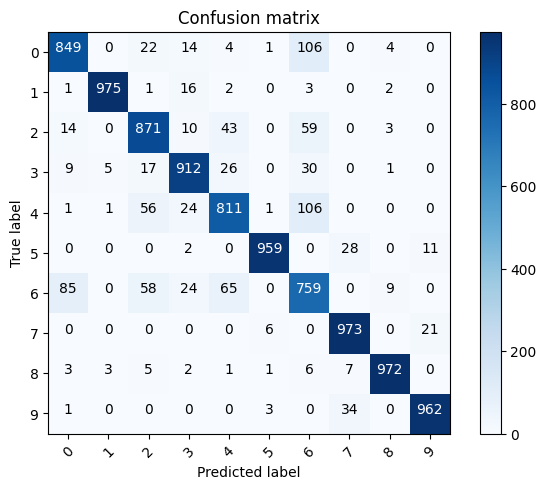

In [21]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs,targets in test_loader:
  inputs = inputs.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [23]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Text(0.5, 1.0, 'True label: T-shirt/top, Predicted: Shirt')

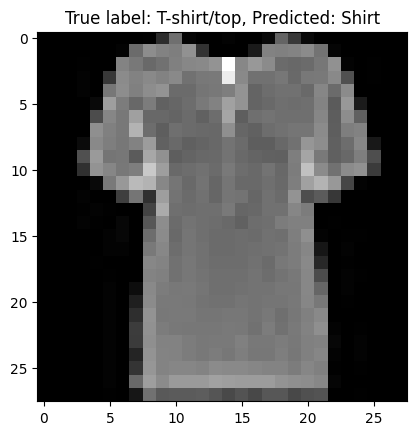

In [26]:
p_test = p_test.astype(np.uint8)
misclassified_index = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_index)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s, Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]))
